In [18]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision.transforms as T

In [19]:
import wandb

wandb.init(project="DQN_messiest", entity="xdvisch")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.12) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
wandb: Currently logged in as: xdvisch. Use `wandb login --relogin` to force relogin


In [20]:
env = gym.make('CartPole-v1',  render_mode='rgb_array').unwrapped

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

In [21]:
# if gpu is to be used
use_cuda = torch.cuda.is_available()
FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if use_cuda else torch.LongTensor
ByteTensor = torch.cuda.ByteTensor if use_cuda else torch.ByteTensor

Tensor = FloatTensor


Transition = namedtuple(
    'Transition',
    ('state', 'action', 'next_state', 'reward')
)


class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)

        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [22]:
class DQN(nn.Module):

    def __init__(self):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=5, stride=2)
        self.bn3 = nn.BatchNorm2d(32)
        self.head = nn.Linear(448, 2)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        return self.head(x.view(x.size(0), -1))


resize = T.Compose([
    T.ToPILImage(),
    T.Resize(40, interpolation=Image.CUBIC),
    T.ToTensor(),
])

/tmp/ipykernel_259/2250486003.py:22: DeprecationWarning: CUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  T.Resize(40, interpolation=Image.CUBIC),
/home/xdvisch/.local/lib/python3.8/site-packages/torchvision/transforms/transforms.py:332: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(


In [23]:
# This is based on the code from gym.
screen_width = 600


def get_cart_location():
    world_width = env.x_threshold * 2
    scale = screen_width / world_width

    return int(env.state[0] * scale + screen_width / 2.0)  # MIDDLE OF CART


def get_screen():
    screen = env.render().transpose(
        (2, 0, 1))  # transpose into torch order (CHW)
    # Strip off the top and bottom of the screen

    # print("Screen Size:", screen.shape)
    # print("Clipped Size:", screen[:, 160:320].shape)

    screen = screen[:, 160:320]  # all channels,
    view_width = 320
    cart_location = get_cart_location()
    if cart_location < view_width // 2:
        slice_range = slice(view_width)
    elif cart_location > (screen_width - view_width // 2):
        slice_range = slice(-view_width, None)
    else:
        slice_range = slice(cart_location - view_width // 2,
                            cart_location + view_width // 2)
    # Strip off the edges, so that we have a square image centered on a cart
    screen = screen[:, :, slice_range]
    # Convert to float, rescare, convert to torch tensor
    # (this doesn't require a copy)
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
    screen = torch.from_numpy(screen)
    # Resize, and add a batch dimension (BCHW)
    return resize(screen).unsqueeze(0).type(Tensor)

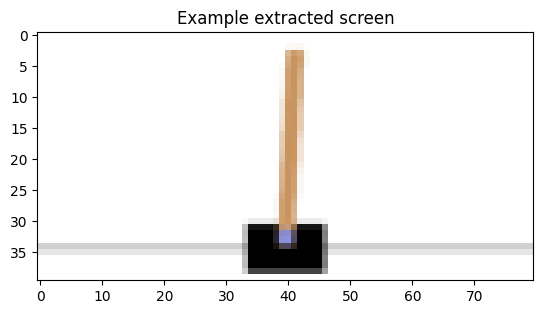

In [24]:

env.reset()
plt.figure()
plt.imshow(
    get_screen().cpu().squeeze(0).permute(1, 2, 0).numpy(),
    interpolation='none',
)
plt.title('Example extracted screen')
plt.show()


BATCH_SIZE = 128
GAMMA = 0.999
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200
TARGET_UPDATE = 10


In [25]:
policy_net = DQN()
target_net = DQN()
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

if use_cuda:
    policy_net.cuda()
    target_net.cuda()

optimizer = optim.RMSprop(policy_net.parameters())
memory = ReplayMemory(10000)


steps_done = 0

In [26]:

def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        return policy_net(
            Variable(state, volatile=True).type(FloatTensor)).data.max(1)[1].view(1, 1)
    else:
        return LongTensor([[random.randrange(2)]])


episode_durations = []

In [27]:
def plot_durations():
    plt.figure(2)
    plt.clf()
    durations_t = torch.FloatTensor(episode_durations)
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        display.clear_output(wait=True)
        display.display(plt.gcf())


In [28]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see http://stackoverflow.com/a/19343/3343043 for
    # detailed explanation).
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    non_final_mask = ByteTensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)))
    non_final_next_states = Variable(torch.cat([s for s in batch.next_state
                                                if s is not None]),
                                     volatile=True)
    state_batch = Variable(torch.cat(batch.state))
    action_batch = Variable(torch.cat(batch.action))
    reward_batch = Variable(torch.cat(batch.reward))

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    next_state_values = Variable(torch.zeros(BATCH_SIZE).type(Tensor))
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0]
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch
    # Undo volatility (which was used to prevent unnecessary gradients)
    expected_state_action_values = Variable(expected_state_action_values.data)

    # Compute Huber loss
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values)

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

In [30]:
# Define the custom x axis metric
wandb.define_metric("episode")

# Define which metrics to plot against that x-axis
wandb.define_metric("duration", step_metric='episode')

num_episodes = 5000
for i_episode in range(num_episodes):
    # Initialize the environment and state
    env.reset()
    last_screen = get_screen()
    current_screen = get_screen()
    state = current_screen - last_screen
    for t in count():
        # Select and perform an action
        action = select_action(state)
        _, reward, done, _, _ = env.step(action.item())

        reward = Tensor([reward])

        # Observe new state
        last_screen = current_screen
        current_screen = get_screen()
        if not done:
            next_state = current_screen - last_screen
        else:
            next_state = None

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the target network)
        optimize_model()
        if done:
            episode_durations.append(t + 1)
            log_dict = {
                "episode": i_episode + 1,
                
                "duration": t
                }
            wandb.log(log_dict)
            # plot_durations()
            break
    # Update the target network
    if i_episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())


print('Complete')
env.render()
env.close()
plt.ioff()
plt.show()

/tmp/ipykernel_259/1083248004.py:9: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  Variable(state, volatile=True).type(FloatTensor)).data.max(1)[1].view(1, 1)
/tmp/ipykernel_259/1329551276.py:12: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  non_final_next_states = Variable(torch.cat([s for s in batch.next_state
/tmp/ipykernel_259/1329551276.py:25: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  ../aten/src/ATen/native/IndexingUtils.h:28.)
  next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0]
/tmp/ipykernel_259/1329551276.py:32: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.smooth_l1_loss(state_action_va

KeyboardInterrupt: 